# Telco Project
***
### Project Description
Accurately predict customer churn using machine learning classification
algorithms

### Table of Contents:
1. [Planning](#Planning)
2. [Acquisition](#Acquisition)
3. [Preparation](#Preparation)
4. [Exploration](#Exploration)
5. [Modeling](#Modeling)
6. [Evaluation](#Evaluation)

## Planning
---
 - [ ] Goal(s)
     - [ ] Find drivers of customer churn
     - [ ] Accurately predict customer churn at Telco.
 - [ ] Measure(s) of success
     - [ ] Hypothesis testing
     - [ ] Baseline accuracy
     - [ ] 3 classification models
         - [ ] Model performance: train, validate, test
         - [ ] Hyperparameter tuning
 - [ ] Plan to achieve 1 & 2
 - [ ] Develop hypotheses
     - [ ] Brainstorm questions
 
Brainstorming questions to form hypothesis:
1. Do customer's of a certain demographic churn more than the rest?
1. Does service package influence churn?
1. Does having add-on services influence whether a customer churns?
1. Does the payment method influence whether customers churn?


In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from acquire import get_telco_data
from prepare import telco_data_prep, preprocessed_data, data_target_split
warnings.filterwarnings('ignore')

plt.rc('figure', figsize=(16,9))
plt.rc('axes.spines', top=False, right=False)
plt.rc('patch', ec='black', force_edgecolor=True)
plt.rc('font', size=20)

sns.set(rc={'figure.figsize': (16,9)})

## Acquisition
--------------
- [ ] Document process
- [ ] Instructions to acquire data in README
- [x] Upload `.csv` file to repository - file named `telecom_data.csv`
- [x] acquire.py file
    1. [x] Write functions to acquire telco dataset
    2. [x] Write docstring for each function

In [2]:
df_telco = get_telco_data()

In [3]:
df_telco.head()

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,DSL,Month-to-month,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,DSL,Month-to-month,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,DSL,Month-to-month,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,DSL,Month-to-month,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.5,Yes,DSL,Month-to-month,Bank transfer (automatic)


In [4]:
df_telco.describe()

,payment_type_id,contract_type_id,internet_service_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.690473,1.872923,0.162147,32.371149,64.761692
std,1.148907,0.833755,0.737796,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,1.000000,2.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


In [5]:
df_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   contract_type_id          7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [6]:
df_telco.nunique()

payment_type_id                4
contract_type_id               3
internet_service_type_id       3
customer_id                 7043
gender                         2
senior_citizen                 2
partner                        2
dependents                     2
tenure                        73
phone_service                  2
multiple_lines                 3
online_security                3
online_backup                  3
device_protection              3
tech_support                   3
streaming_tv                   3
streaming_movies               3
paperless_billing              2
monthly_charges             1585
total_charges               6531
churn                          2
internet_service_type          3
contract_type                  3
payment_type                   4
dtype: int64

In [7]:
object_columns = df_telco.nunique()[
    (df_telco.nunique() <= 4) & (df_telco.nunique() > 2)]
object_columns = object_columns.index.to_list()

In [8]:
for column in object_columns:
    print(df_telco[column].value_counts().sort_index())
    print('')

1    2365
2    1612
3    1544
4    1522
Name: payment_type_id, dtype: int64

1    3875
2    1473
3    1695
Name: contract_type_id, dtype: int64

1    2421
2    3096
3    1526
Name: internet_service_type_id, dtype: int64

No                  3390
No phone service     682
Yes                 2971
Name: multiple_lines, dtype: int64

No                     3498
No internet service    1526
Yes                    2019
Name: online_security, dtype: int64

No                     3088
No internet service    1526
Yes                    2429
Name: online_backup, dtype: int64

No                     3095
No internet service    1526
Yes                    2422
Name: device_protection, dtype: int64

No                     3473
No internet service    1526
Yes                    2044
Name: tech_support, dtype: int64

No                     2810
No internet service    1526
Yes                    2707
Name: streaming_tv, dtype: int64

No                     2785
No internet service    1526
Yes          

In [9]:
# Data Dictionaries for payments, contracts, and internet
# Key == ID number, non-zero value in row correspond to matching ID number
payments = pd.crosstab(df_telco.payment_type_id, df_telco.payment_type)
contracts = pd.crosstab(df_telco.contract_type_id, df_telco.contract_type)
internet = pd.crosstab(df_telco.internet_service_type_id, df_telco.internet_service_type)

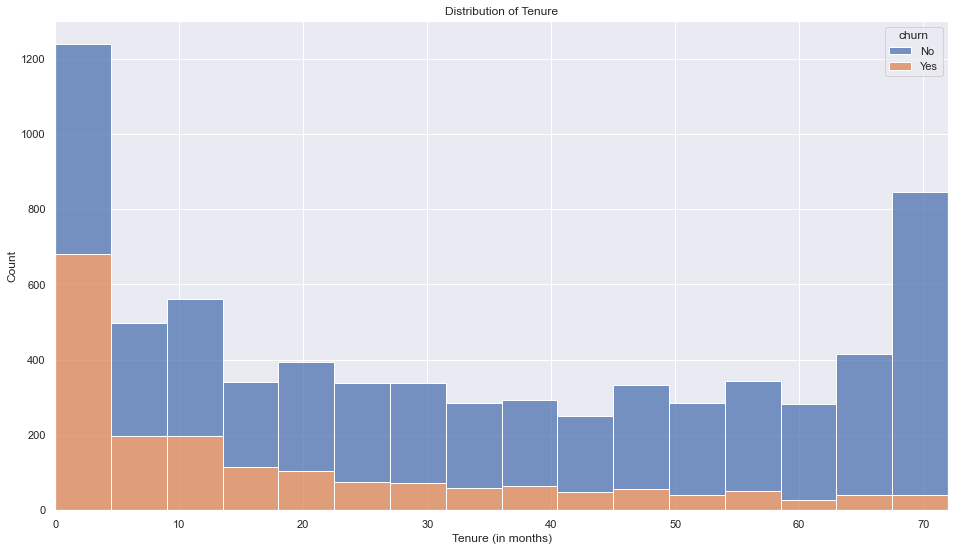

In [10]:
# Distribution of Tenure
sns.histplot(df_telco,
             x=df_telco.tenure,
             hue='churn',
             multiple='stack')

plt.title("Distribution of Tenure")
plt.xlabel('Tenure (in months)')

plt.xlim(0, df_telco.tenure.max());

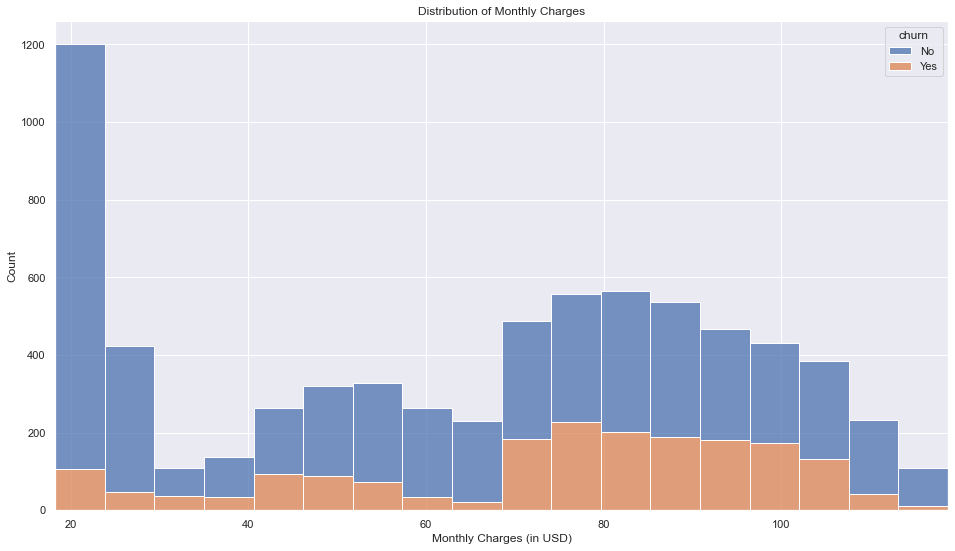

In [11]:
# Distribution of Monthly Charges
sns.histplot(data=df_telco,
            x=df_telco.monthly_charges,
            hue=df_telco.churn,
            multiple='stack')

plt.title("Distribution of Monthly Charges")
plt.xlabel('Monthly Charges (in USD)')

plt.xlim(df_telco.monthly_charges.min(),
         df_telco.monthly_charges.max());

In [12]:
# Service Packages
pd.crosstab(df_telco.phone_service, df_telco.internet_service_type)

internet_service_type,DSL,Fiber optic,None
phone_service,,,
No,682,0,0
Yes,1739,3096,1526


## Preparation and Processing
---
#### Data Cleaning
- No duplicate values
- 24 attributes
    - Clean `total_charges` column
        - Convert dtype from string to float
        - Drop customers with 0 `total_charges`. #new_customers
    - Convert `churn` column values from "No"/"Yes" to 0/1
    - Rename `tenure` to `tenure_in_months`
    

#### Data Preparation

- Create encoded attributes

In [13]:
df = telco_data_prep()

In [14]:
# Scale values in iteration 2
df.describe(exclude='uint8')

,customer_id,tenure_in_months,monthly_charges,total_charges,tenure_in_years,churn
count,7043,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
unique,7043,NaN,NaN,NaN,NaN,NaN
top,5445-UTODQ,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,32.371149,64.761692,2279.734304,2.697402,0.265370
std,NaN,24.559481,30.090047,2266.794470,2.046968,0.441561
min,NaN,0.000000,18.250000,0.000000,0.000000,0.000000
25%,NaN,9.000000,35.500000,398.550000,0.750000,0.000000
50%,NaN,29.000000,70.350000,1394.550000,2.420000,0.000000
75%,NaN,55.000000,89.850000,3786.600000,4.580000,1.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            7043 non-null   object 
 1   tenure_in_months                       7043 non-null   int64  
 2   monthly_charges                        7043 non-null   float64
 3   total_charges                          7043 non-null   float64
 4   tenure_in_years                        7043 non-null   float64
 5   gender_Male                            7043 non-null   uint8  
 6   partner_Yes                            7043 non-null   uint8  
 7   dependents_Yes                         7043 non-null   uint8  
 8   phone_service_Yes                      7043 non-null   uint8  
 9   multiple_lines_No phone service        7043 non-null   uint8  
 10  multiple_lines_Yes                     7043 non-null   uint8  
 11  onli

## Data Exploration
---
- [ ] Statistical Analysis
    - [ ] Restate hypothesis here
    - [ ] Test hypotheses
    - [ ] Plot distributions
- [ ] Create visuals
- [ ] Present and summarize key findings

Hypotheses


In [16]:
train, validate, test = preprocessed_data()

In [17]:
train = train.drop(columns='customer_id')
validate = validate.drop(columns='customer_id')
test = test.drop(columns='customer_id')

In [18]:
X_train, y_train = data_target_split(train)

In [24]:
X_train

,tenure_in_months,monthly_charges,total_charges,tenure_in_years,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,internet_service_type_Fiber optic,internet_service_type_None,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6869,13,20.00,268.45,1.08,1,0,0,1,0,0,...,1,0,0,0,1,0,1,1,0,0
1020,10,51.20,498.25,0.83,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3308,35,75.20,2576.20,2.92,1,1,0,1,0,1,...,0,0,1,1,0,0,0,0,1,0
2193,2,80.20,146.05,0.17,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,1,0
6219,72,107.50,7853.70,6.00,0,0,0,1,0,1,...,0,1,1,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4005,46,70.60,3231.05,3.83,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
1268,4,75.35,273.40,0.33,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1963,5,71.45,371.60,0.42,1,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,1
4497,54,94.10,5060.90,4.50,0,0,0,1,0,0,...,0,1,1,1,0,1,0,1,0,0


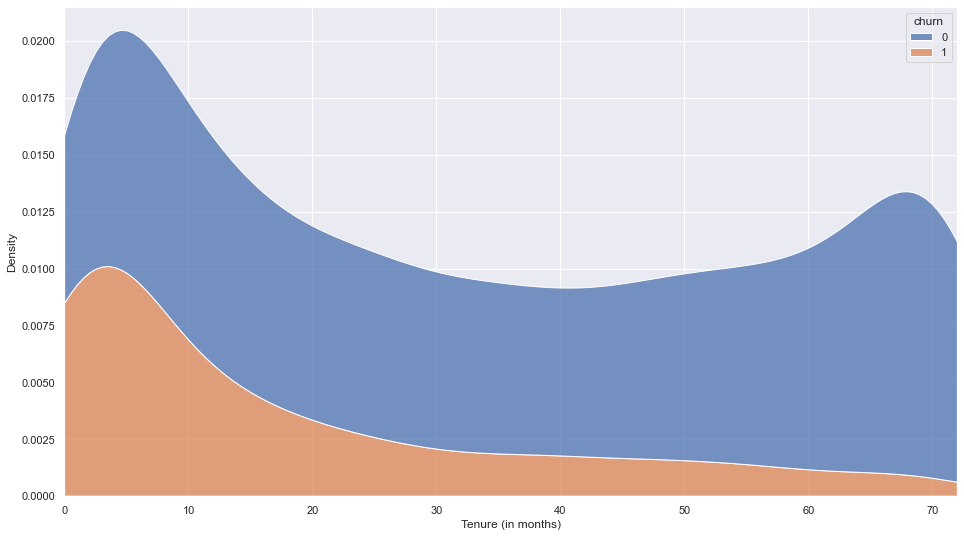

In [21]:
# Distribution of Tenure
sns.kdeplot(data=train,
            x=train.tenure_in_months,
            hue=train.churn,
            multiple='stack')

plt.xlabel('Tenure (in months)')
plt.xlim(0, train.tenure_in_months.max());

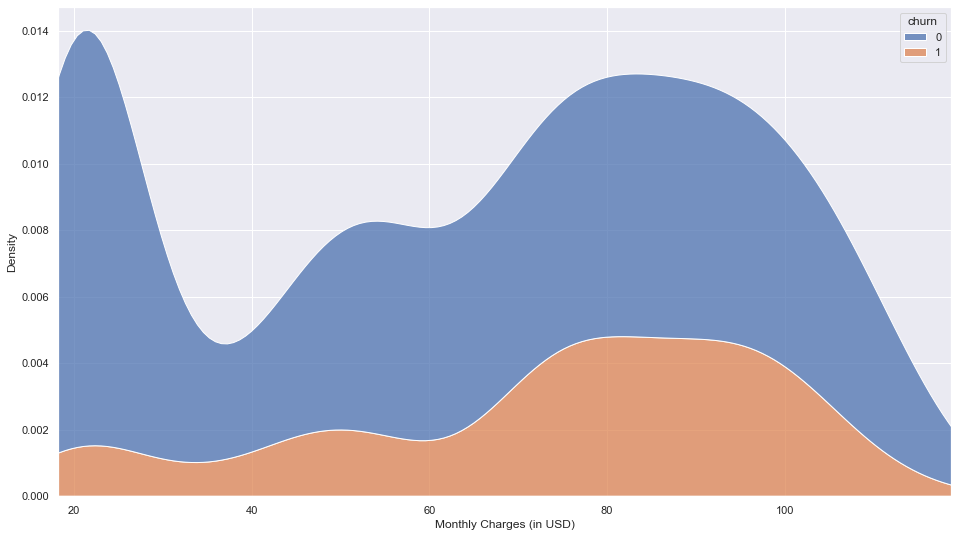

In [22]:
sns.kdeplot(data=train,
            x=train.monthly_charges,
            hue=train.churn,
            multiple='stack')
plt.xlabel('Monthly Charges (in USD)')
plt.xlim(df_telco.monthly_charges.min(),
         df_telco.monthly_charges.max());

## Modeling
---
4 _Basic Classification Models_
---

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [26]:
X_validate, y_validate = data_target_split(validate)
X_test, y_test = data_target_split(test)

In [27]:
# Baseline Accuracy
baseline_accuracy = df.churn.value_counts(normalize=True)[0]
print(f"Baseline Accuracy: {baseline_accuracy:.2%}")

Baseline Accuracy: 73.46%


### Logistic Regression

In [28]:
logreg = LogisticRegression().fit(X_train, y_train)
logreg_train_accuracy = logreg.score(X_train, y_train)

### Decision Tree

In [29]:
forest = DecisionTreeClassifier().fit(X_train, y_train)
forest_train_accuracy = forest.score(X_train, y_train)

### Random Forest

In [30]:
rforest = RandomForestClassifier().fit(X_train, y_train)
r_forest_train_accuracy = rforest.score(X_train, y_train)

### K Nearest Neighbors

In [31]:
knn = KNeighborsClassifier().fit(X_train, y_train)
knn_train_accuracy = knn.score(X_train, y_train)

## Evaluation
---
### Training Set Accuracy

In [32]:
print(f"Baseline Accuracy --- {baseline_accuracy:.2%}")
print("")
print(f"Logistic Regression Accuracy --- {logreg_train_accuracy:.2%}")
print(f"Decision Tree Accuracy --- {forest_train_accuracy:.2%}")
print(f"Random Forest Accuracy --- {r_forest_train_accuracy:.2%}")
print(f"KNN Accuracy Accuracy --- {knn_train_accuracy:.2%}")

Baseline Accuracy --- 73.46%

Logistic Regression Accuracy --- 81.21%
Decision Tree Accuracy --- 99.82%
Random Forest Accuracy --- 99.82%
KNN Accuracy Accuracy --- 83.13%


### Validation Set Accuracy

In [33]:
logreg_validate_accuracy = logreg.score(X_validate, y_validate)
forest_validate_accuracy = forest.score(X_validate, y_validate)
r_forest_validate_accuracy = rforest.score(X_validate, y_validate)
knn_validate_accuracy = knn.score(X_validate, y_validate)

print(f"Logistic Regression Accuracy --- {logreg_validate_accuracy:.2%}")
print(f"Decision Tree Accuracy --- {forest_validate_accuracy:.2%}")
print(f"Random Forest Accuracy --- {r_forest_validate_accuracy:.2%}")
print(f"KNN Accuracy Accuracy --- {knn_validate_accuracy:.2%}")

Logistic Regression Accuracy --- 80.19%
Decision Tree Accuracy --- 73.33%
Random Forest Accuracy --- 77.82%
KNN Accuracy Accuracy --- 75.52%


### Test Set Accuracy

In [34]:
logreg_test_accuracy = logreg.score(X_test, y_test)
print(f"Logistic Regression Accuracy --- {logreg_test_accuracy:.2%}")

Logistic Regression Accuracy --- 78.57%


### Predicting Customer Churn

In [55]:
train, validate, test = preprocessed_data()

In [56]:
df_telco = pd.concat([train, validate, test], axis=0)

In [57]:
customer_ids = df_telco['customer_id']
df_telco_data = df_telco.drop(columns=['customer_id', 'churn'])
df_telco_target = df_telco.churn

In [58]:
telco_accuracy = logreg.score(df_telco_data, df_telco_target)
print(f"Logistic Regression Accuracy on Telco Data --- {telco_accuracy:.2%}")

Logistic Regression Accuracy on Telco Data --- 80.43%


In [95]:
prediction_of_churn = pd.DataFrame({'churn_prediction' : logreg.predict(df_telco_data)})

In [106]:
churn_probability = pd.DataFrame({'churn_probability': logreg.predict_proba(df_telco_data)[:,1]})

In [107]:
customer_churn = pd.concat(
    [customer_ids,
     churn_probability,
     prediction_of_churn],
    axis=1
)

In [115]:
customer_churn.to_csv('customer_churn_predictions.csv')

In [113]:
customer_churn.churn_prediction.value_counts()

0    5458
1    1585
Name: churn_prediction, dtype: int64

In [114]:
customer_churn.churn_prediction.value_counts(normalize=True)

0    0.774954
1    0.225046
Name: churn_prediction, dtype: float64

## Conclusion
---

[Return to the top](#Telco-Project)